In [4]:
# Importing Libraries
import tables
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/Users/eframe/dmi/src')
import compton 
import matplotlib.ticker as ticker
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import xlogy, erf
import math as m

In [5]:
# Inputs for Compton image reconstruction
E, sigma = 440, 2
mu_low, mu_high = -0.4, 1
lever_thres = 14
poses = np.array( [ 0, 315, 270, 225, 180, 135, 90, 45 ] ) * np.pi / 180
inputs = np.array( ['/Users/eframe/Downloads/phantom/phantom1_0deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_45deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_90deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_135deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_180deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_225deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_270deg.h5',
                   '/Users/eframe/Downloads/phantom/phantom1_315deg.h5'] ) 

binsize = 2
sourceX, sourceY, sourceZ = np.mgrid[ -24:26:binsize, -10:12:binsize, -24:26:binsize ]
sourcePixels = np.array( [ sourceX.flatten(), sourceY.flatten(), sourceZ.flatten() ] ).T

In [6]:
# Getting Compton cones from detector data for each pose
interPos, interPos2, coneDir, coneMu = [], [], [], []
for i in np.arange( len( inputs ) ):
    f = tables.open_file( inputs[ i ], 'r' )
    time = f.root.EventData.read()['timestamp']
    duration = ( time[-1] * 10 ** -8 - time[0] * 10 ** -8 ) / 60
    print('minutes:', duration)
    d = f.root.Interactions.Double.read()
    d['x'] = d['x'] - 38 
    d['y'] = d['y'] - 38  
    l22 = d.reshape( int ( len ( d ) / 2 ), 2 ) 

    # Getting Cone Data
    emask = ( l22['energy'].sum( axis = 1 ) >= E - sigma ) & ( l22['energy'].sum( axis = 1 ) <= E + sigma )   
    events_old = l22[emask]
    events = compton.correct_depth( events_old )
    events['z'] = -events['z']
    
    iP, iP2, cD, cM = compton.convertToConeData( events, E, lever_thres )
    
#     # Sequencing Interactions
#     energy1 = np.array( [ events['energy' ][ :, 0 ], events['energy'][ :, 1 ] ] ).T
#     energy2 = np.array( [ events['energy' ][ :, 1 ], events['energy'][ :, 0 ] ] ).T
#     p1 = np.squeeze( np.array( [ events['x'][ :, 0 ], events['y'][ :, 0 ], events['z'][ :, 0 ] ] ) ).T
#     p2 = np.squeeze( np.array( [ events['x'][ :, 1 ], events['y'][ :, 1 ], events['z'][ :, 1 ] ] ) ).T
#     pos1 = np.concatenate( ( [ p1, p2 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )
#     pos2 = np.concatenate( ( [ p2, p1 ] ) , axis = 1 ).reshape( len( p1 ), 2, 3 )

#     P12, P21 = compton.sequence_probability( energy1, pos1, E )
#     mask = ( P12 < P21 )
#     energy = energy1.copy()
#     energy[mask] = energy2[mask]
#     pos = pos1.copy()
#     pos[mask] = pos2[mask]
#     iP, iP2, cD, cM = compton.convertToConeData_SEQ( energy, pos, E, lever_thres )
    
    mask = ( cM > mu_low ) & ( cM < mu_high )
    interPos.append( iP[mask] )
    interPos2.append( iP2[mask] )
    coneMu.append( cM[mask] )
    coneDir.append( cD[mask] )

OSError: ``/Users/eframe/Downloads/phantom/phantom1_0deg.h5`` does not exist

0.0


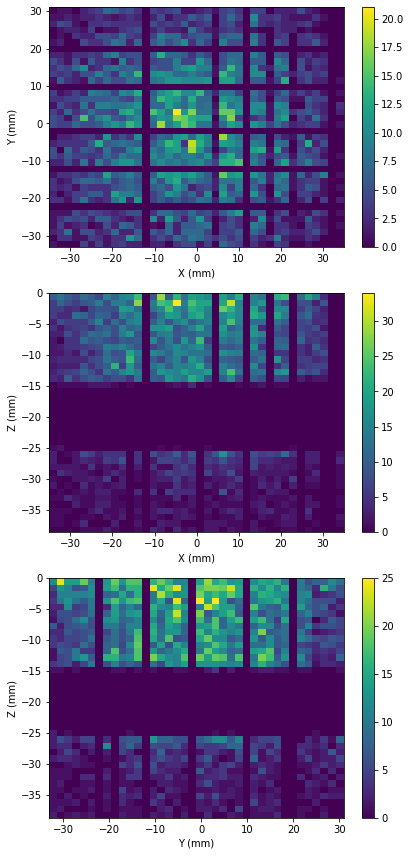

5.497787143782138


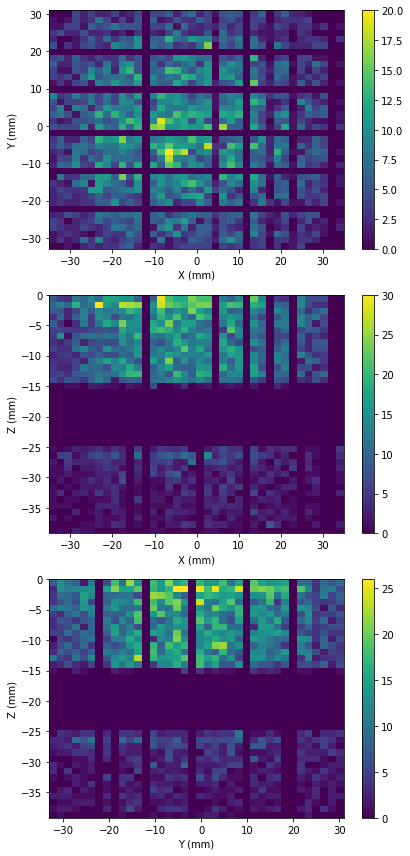

4.71238898038469


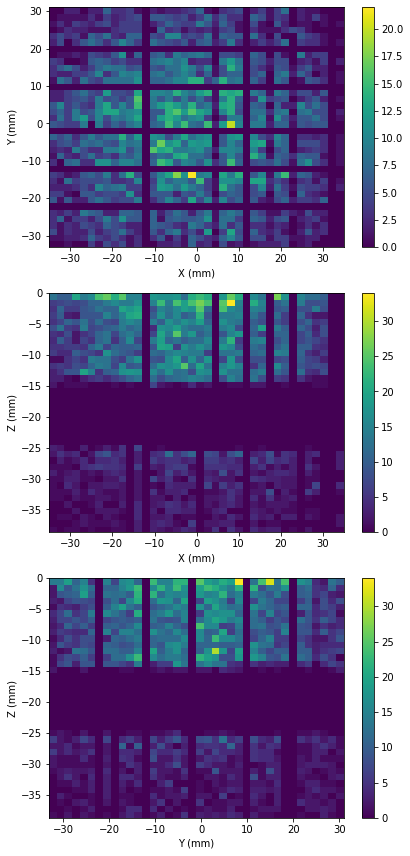

3.9269908169872414


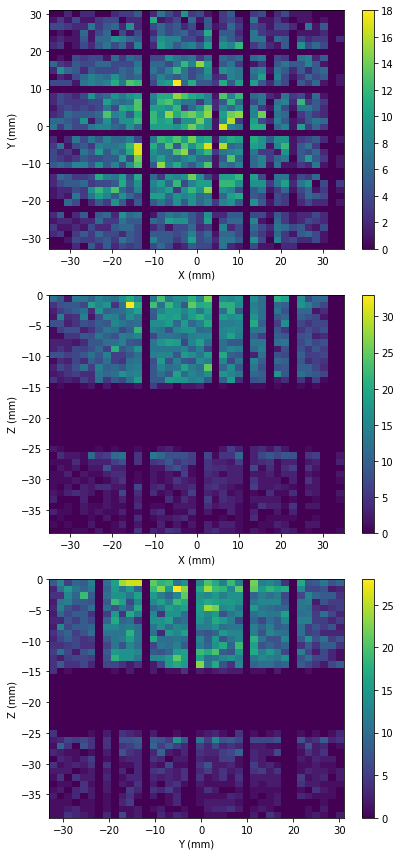

3.141592653589793


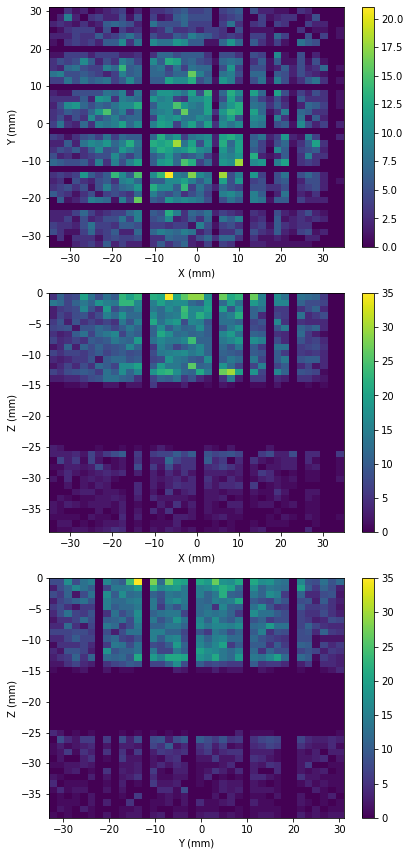

2.356194490192345


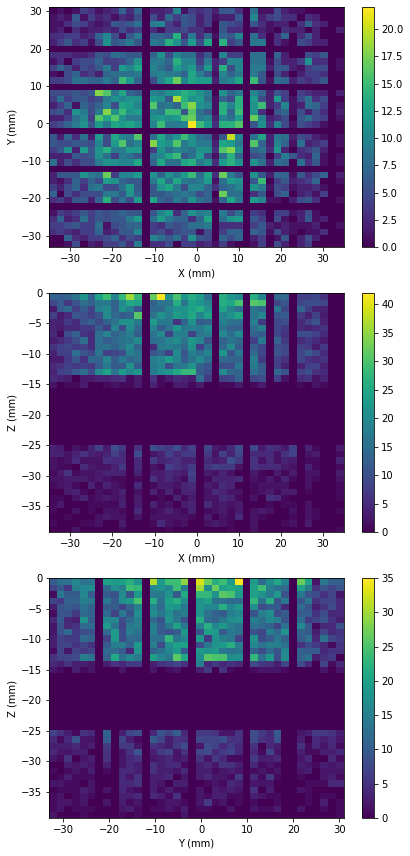

1.5707963267948966


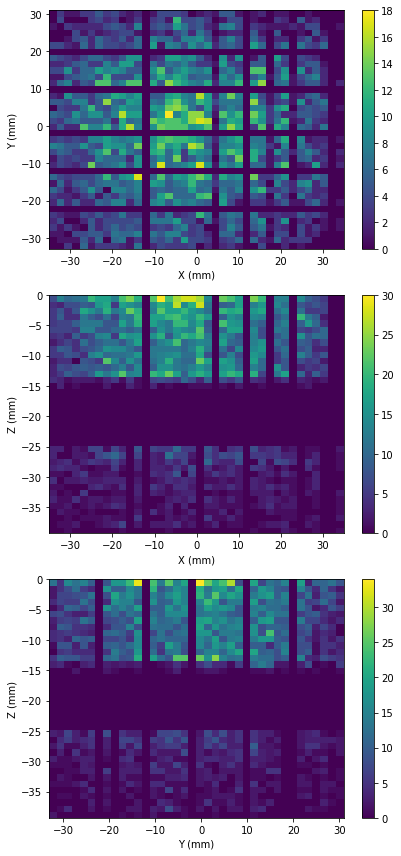

0.7853981633974483


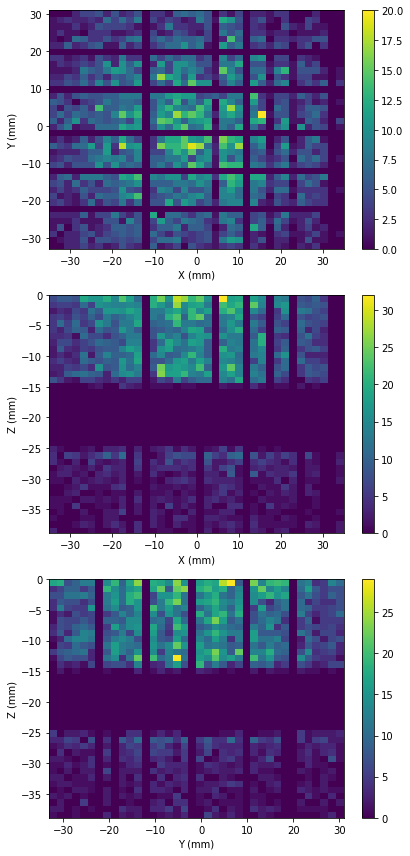

In [65]:
# Heatmap of interaction locations
get_ipython().run_line_magic('matplotlib', 'inline')
for i in np.arange( len( interPos ) ):
    print( poses[i] )
    pos = interPos[i]
    plt.figure( figsize=( 6,12 ) )
    # XY
    plt.subplot( 311 )
    plt.hist2d( pos[ :, 0 ], pos[ :, 1 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "X (mm)" )
    plt.ylabel( "Y (mm)" )
    # XZ
    plt.subplot( 312 )
    plt.hist2d(pos[ :, 0 ], pos[ :, 2 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "X (mm)" )
    plt.ylabel( "Z (mm)" )
    # YZ
    plt.subplot( 313 )
    plt.hist2d(pos[ :, 1 ], pos[ :, 2 ], bins = ( 38, 38 ) )
    plt.colorbar()
    plt.xlabel( "Y (mm)" )
    plt.ylabel( "Z (mm)" )
    # Render
    plt.tight_layout()
    plt.show()

In [92]:
# Defining new source image space for each pose
center = np.array( [ 0, 0, 60] )
sourcePixelsNew = []
for i in np.arange( len( poses ) ):
    ang = poses[ i ]
    R = np.array( [  [ np.cos( ang ), 0, np.sin( ang ) ], [ 0, 1, 0 ], [ -np.sin( ang ), 0, np.cos( ang ) ] ] ).T
    B = np.array( [ [ 1, 0, 0 ], [ 0, 1, 0 ], [ 0, 0, 1 ] ] )
    K = np.array( np.dot( R, B ) )
    sourcePixelsNew.append(  np.dot( sourcePixels, R ) + center ) 

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


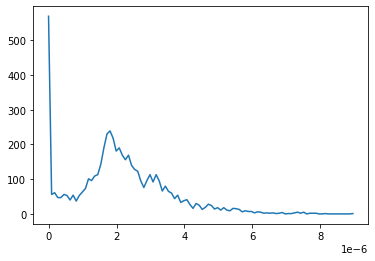

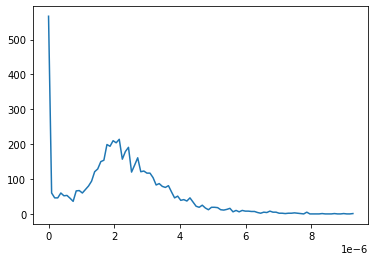

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


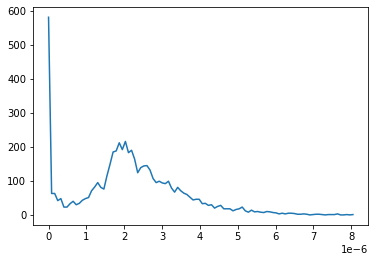

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


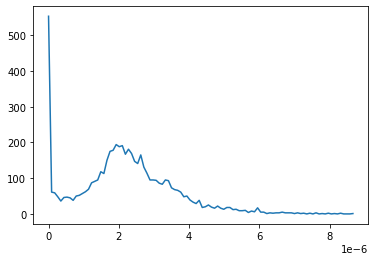

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


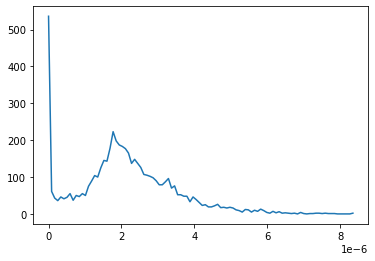

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


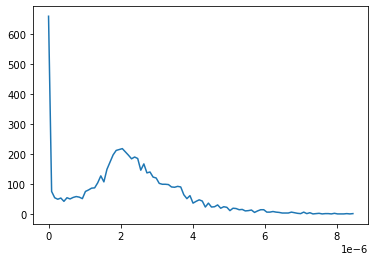

/Users/eframe/dmi/src/compton.py:139: RuntimeWarning: invalid value encountered in sqrt
  sin_nu = np.sqrt(1 - nu**2)


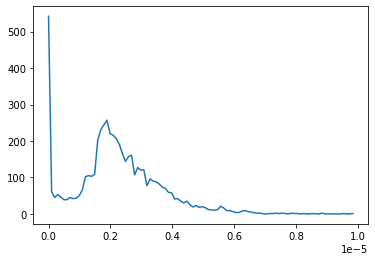

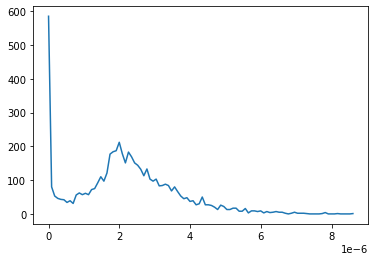

In [93]:
# Getting Backprojected Data
get_ipython().run_line_magic('matplotlib', 'inline')
backproj, backproj_inner, backproj_outer = [], [], []
for i in np.arange( len(interPos) ):
    bp = compton.coneVoxel2( sourcePixelsNew[i], interPos[i], coneDir[i], coneMu[i], 0.05, binsize  )
    
    xcoord = sourcePixels[:,0] 
    ycoord = sourcePixels[:,1]
    zcoord = sourcePixels[:,2]
    
    bp_outer = bp.copy()
    bp_inner = bp.copy()
    
    mask_outer = ( np.sqrt( zcoord ** 2 + xcoord ** 2  ) > 24 ) 
    mask_inner = ( np.sqrt( zcoord ** 2 + xcoord ** 2  ) > 20 ) 
    
    bp_outer.T[mask_outer] = 0
    bp_inner.T[mask_inner] = 0
    
    v = ( bp ).sum( 1 )

    
    mask2 = np.isnan( v ) | ( v < 1e-20 )
    backproj.append( bp[~mask2] )
    backproj_inner.append( bp_inner[~mask2] )
    backproj_outer.append( bp_outer[~mask2] )
    
    hist, bins = np.histogram( v[~mask2], bins = 100 )
    plt.plot( bins[ :-1 ], hist )
    plt.show()

In [94]:
# arrays = np.concatenate((backproj[0],backproj[1],backproj[2],backproj[3],
#                          backproj[4],backproj[5],backproj[6],backproj[7]))
# arrays_inner = np.concatenate((backproj_inner[0],backproj_inner[1],backproj_inner[2],backproj_inner[3],
#                          backproj_inner[4],backproj_inner[5],backproj_inner[6],backproj_inner[7]))
# arrays_outer = np.concatenate((backproj_outer[0],backproj_outer[1],backproj_outer[2],backproj_outer[3],
#                          backproj_outer[4],backproj_outer[5],backproj_outer[6],backproj_outer[7]))

# bp = np.copy( np.array( arrays ) )  
# bp_inner = np.copy( np.array( arrays_inner ) )  
# bp_outer = np.copy( np.array( arrays_outer ) ) 
# v = ( bp ).sum( 1 )
# v_inner = ( bp_inner ).sum(1)
# v_outer = ( bp_outer ).sum(1)
# frac_inner = v_inner 
# frac_outer = v_outer 

# %matplotlib inline
# fig, ax = plt.subplots()
# im = plt.hist2d(frac_inner, frac_outer,  bins=100, cmap='jet')
# fig.colorbar(im[3], ax=ax)
# plt.xlabel('w(inner)')
# plt.ylabel('w(outer)')
# plt.show()

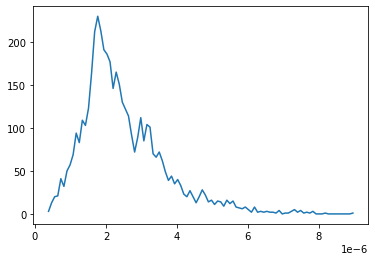

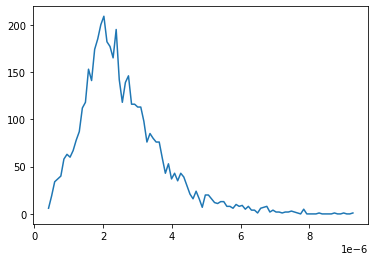

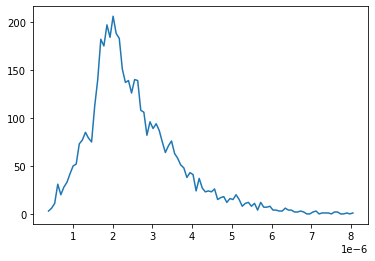

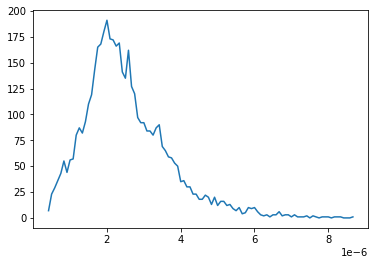

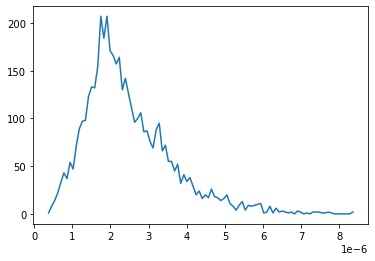

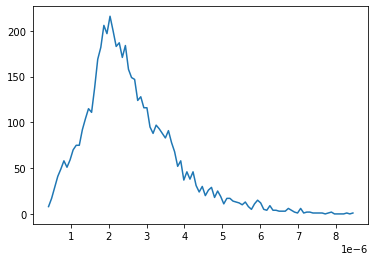

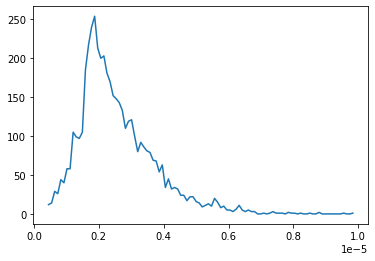

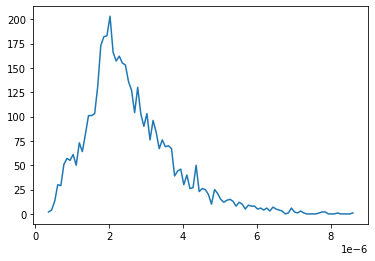

In [104]:
%matplotlib inline
backproj_New = []
for i in np.arange( len(interPos) ):
    bp = np.copy( np.array( backproj[i] ) ) 
    bp_inner = np.copy( np.array( backproj_inner[i] ) )
    bp_outer = np.copy( np.array( backproj_outer[i] ) )
    v = bp.sum(1)
    v_inner = ( bp_inner ).sum(1)
    v_outer = ( bp_outer ).sum(1)
    mask = (v_outer > 0.25e-6 ) & (v_inner > 0 )
    backproj_New.append( bp[mask] )
    hist, bins = np.histogram( bp[mask].sum(1), bins = 100 )
    plt.plot( bins[ :-1 ], hist)
    plt.show()

In [105]:
# Calculating Sensitivity Map 1
sensMap = []
eps = 1e-10
det = 37

for i in np.arange( len( poses ) ):
    x = np.round( sourcePixelsNew[i][:,0]  ).astype(int)
    y = np.round( sourcePixelsNew[i][:,1] ).astype(int)
    z = np.round( sourcePixelsNew[i][:,2] ).astype(int)
    R = np.sqrt( x ** 2 + y ** 2 + z ** 2)
    c1 = x + det
    c2 = x - det
    d1 = y + det
    d2 = y - det
    a1 = c1 / ( np.sqrt( c1 ** 2 + z ** 2 ) + eps )
    b1 = d1 / ( np.sqrt( d1 ** 2 + z ** 2 ) + eps )
    a2 = c2 / ( np.sqrt( c2 ** 2 + z ** 2 ) + eps )
    b2 = d2 / ( np.sqrt( d2 ** 2 + z ** 2 ) + eps )
    firstsum = np.arcsin( a1 * b1 ) * ( ( -1 ) ** 2 ) + np.arcsin( a1 * b2 ) * ( ( -1 ) ** 3 )
    secondsum = np.arcsin( a2 * b1 ) * ( ( -1 ) ** 3 ) + np.arcsin( a2 * b2 ) * ( ( -1 ) ** 4 )
    sens =  ( firstsum + secondsum ) / ( 4 * np.pi ) 
    sensMap.append( sens )
sens1 = np.array( sensMap ).sum(0)

0


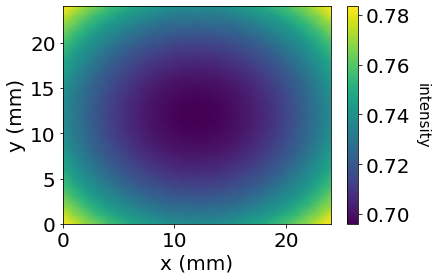

1


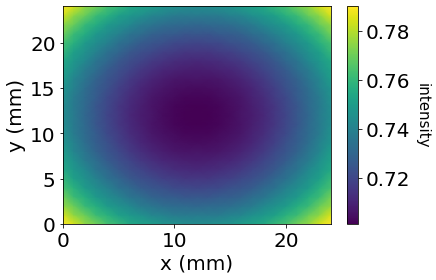

2


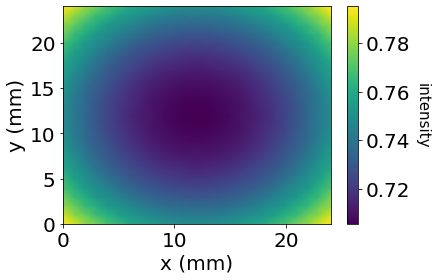

3


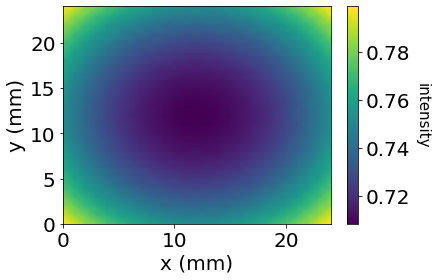

4


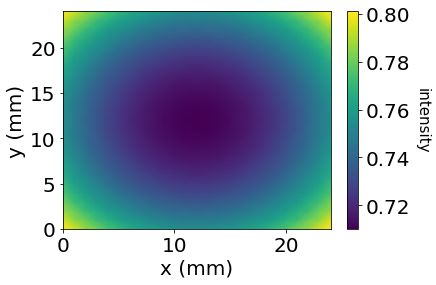

5


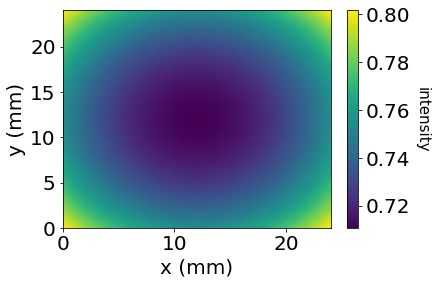

6


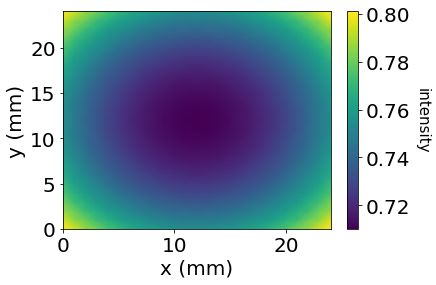

7


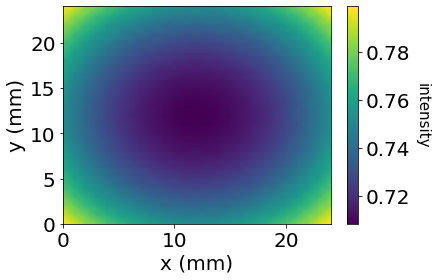

8


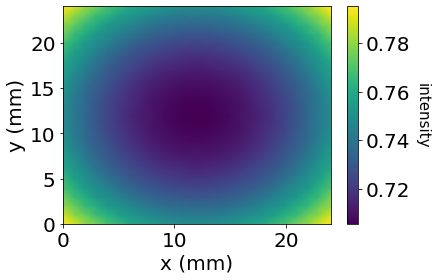

9


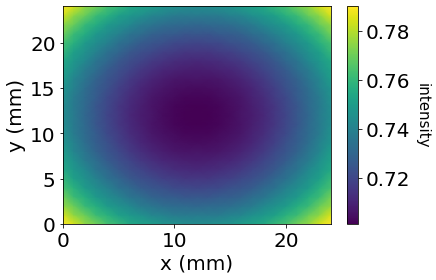

10


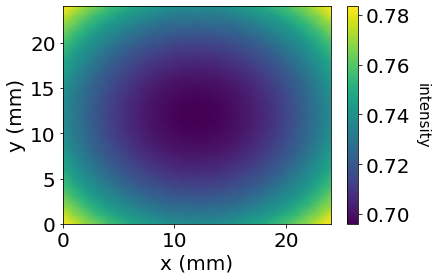

11


IndexError: index 11 is out of bounds for axis 1 with size 11

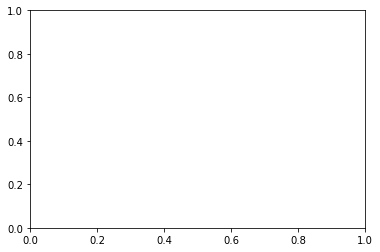

In [106]:
%matplotlib inline
sens_grid = sens1.reshape( sourceX.shape )
a, b = min(sens_grid.flatten()), max(sens_grid.flatten())
for i in np.arange( sourceX.shape[0] ):
    print(i)
    fig, ax = plt.subplots()
    grid = sens_grid[ :, i, :] 
    im = ax.pcolormesh( grid.T,  shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    plt.show()

In [ ]:
det_data = backproj_New.copy()
nIter = 1000
eta = 5e-4
eps = 0.01
sensitivity = sens1.copy()
maxsens = sensitivity.max()
sens = np.mean(sensitivity)
lamb = np.ones( len( sourcePixels ) )
for n in np.arange( nIter ):
    print( 'iteration: %i of %i' %( n + 1, nIter ) )
    outerSum = np.zeros( ( len( sourcePixels )  ), dtype = 'float32' )
    ratio = np.zeros( len( sourcePixels ) )
    lamb3D = np.pad( lamb.copy().reshape( sourceX.shape ), 1 )
    P_alpha = np.zeros_like( lamb3D )
    for i in np.arange( 1, lamb3D.shape[0] - 1 ):
        for j in np.arange( 1, lamb3D.shape[1] - 1 ):
            for k in np.arange( 1, lamb3D.shape[2] - 1 ):
                val = -eta * maxsens * \
                                    ( np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k] ) + \

                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k-1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j][k-1]  ) + \

                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j-1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j+1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j-1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i-1][j+1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j-1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i+1][j+1][k+1] ) + \
                                    np.sign( lamb3D[i][j][k] - lamb3D[i][j][k+1]  ) )
                P_alpha[i][j][k] = val
    P_pos = ( 0.5 * ( np.abs( P_alpha ) + P_alpha ) )[ 1:-1, 1:-1, 1:-1 ].flatten()
    P_neg = ( 0.5 * ( np.abs( P_alpha ) - P_alpha ) )[ 1:-1, 1:-1, 1:-1 ].flatten()
    for p in np.arange( 0, len(poses), 1 ):
        # for loop over detector pixels
        sysMat = det_data[p]
        projExpected = np.dot( sysMat, lamb )
        frac = np.divide( sysMat.T, projExpected, out = np.zeros_like( sysMat.T ), where = projExpected != 0 )
        ratio = ratio + frac.sum(1) 
    #lamb = lamb * ( sensitivity / ( sensitivity ** 2 + P_neg * sensitivity + eps ** 2 * maxsens ** 2 ) ) * ( ratio + P_pos )
    lamb = lamb * ( 1 / ( sens + P_neg ) ) * ( ratio + P_pos )
    if ( n == 9 ) | ( n == 19 ) | ( n == 29 ) | ( n == 39 ) | ( n == 49 ) | \
    ( n == 59 ) | ( n == 69 ) | ( n == 79 ) | ( n == 89 ) | ( n == 99 ) | \
    ( n == 199 ) | ( n == 299 ) | ( n == 399 ) | ( n == 499 ) | ( n == 599 ) | \
    ( n == 699 ) | ( n == 0 ) | ( n == 899 ) | ( n == 249 ) | ( n == 149 ):
        f = tables.open_file( '/Users/eframe/Downloads/phantom_' + str(n+1) + '.h5', 'w')
        f.create_array('/', 'image', lamb)
        f.close()

iteration: 1 of 1000
iteration: 2 of 1000
iteration: 3 of 1000
iteration: 4 of 1000
iteration: 5 of 1000
iteration: 6 of 1000
iteration: 7 of 1000
iteration: 8 of 1000
iteration: 9 of 1000
iteration: 10 of 1000
iteration: 11 of 1000
iteration: 12 of 1000
iteration: 13 of 1000
iteration: 14 of 1000
iteration: 15 of 1000
iteration: 16 of 1000
iteration: 17 of 1000
iteration: 18 of 1000
iteration: 19 of 1000
iteration: 20 of 1000
iteration: 21 of 1000
iteration: 22 of 1000
iteration: 23 of 1000
iteration: 24 of 1000
iteration: 25 of 1000
iteration: 26 of 1000
iteration: 27 of 1000
iteration: 28 of 1000
iteration: 29 of 1000
iteration: 30 of 1000
iteration: 31 of 1000
iteration: 32 of 1000
iteration: 33 of 1000
iteration: 34 of 1000
iteration: 35 of 1000
